In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "tiny"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))
# df['1_run_id'] = df['1_run_id'].astype('int64')
# df.sort_values(['driver_invocation', 'workload_invocation', 'provider', 'region', '1_run_id'], inplace=True, ignore_index=True)

In [3]:
df[['driver_invocation', 'workload_invocation', 'provider', 'region', '1_run_id']]

,driver_invocation,workload_invocation,provider,region,1_run_id
0,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,28
1,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,69
2,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,74
3,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,86
4,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,103
...,...,...,...,...,...
499531,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,19
499532,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,35
499533,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,83
499534,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,90


In [4]:
df.columns

Index(['driver_invocation', 'workload_invocation', 'provider', 'region',
       'dirty_measurement', 'folder_uuid', '1_run_id', '2_thread_id',
       'SAAFMemoryDeltaError', 'SAAFMemoryError', 'contextSwitches',
       'contextSwitchesDelta', 'cpuIdle', 'cpuIdleDelta', 'cpuIowait',
       'cpuIowaitDelta', 'cpuIrqDelta', 'cpuKrn', 'cpuKrnDelta', 'cpuModel',
       'cpuNice', 'cpuSoftIrq', 'cpuSoftIrqDelta', 'cpuType', 'cpuUsr',
       'cpuUsrDelta', 'endTime', 'frameworkRuntime', 'frameworkRuntimeDeltas',
       'freeMemory', 'functionName', 'latency', 'linuxVersion', 'newcontainer',
       'roundTripTime', 'runtime', 'runtimeOverlap', 'startTime',
       'totalMemory', 'userRuntime', 'uuid', 'vmcpusteal', 'vmcpustealDelta',
       'vmuptime', 'containerID', 'functionMemory', 'pageFaults',
       'pageFaultsDelta', 'vmID', 'dow_utc', 'tod_utc', 'timezone',
       'measure group', 'local_dow', 'local_tod'],
      dtype='object')

In [5]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = df.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
    for measure_group in row['measure group']:
        region = row['region']
        provider = row['provider']
        measure_group = row['measure group'][0]
        provider_region_mapping[f"({provider}, {region})"] = {'region': region, 'measure group': measure_group, 'provider': provider}
        provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {'region': region, 'measure group': measure_group, 'provider': provider}

# Mean Runtime and CV

In [42]:
cov_df = df.groupby( ['provider', 'region'], observed=True)['runtime'].apply(utils.cov)

In [43]:
cov_df

provider  region                 
AWS       ap-northeast-1             0.165571
          ap-south-1                 0.154348
          ap-southeast-2             0.148271
          ca-central-1               0.160348
          eu-central-1               0.140846
          eu-west-2                  0.158220
          sa-east-1                  0.141469
          us-east-1                  0.146367
          us-west-1                  0.159309
          us-west-2                  0.155718
AZURE     australiaeast              0.212299
          brazilsouth                0.285020
          centralindia               0.288369
          eastus                     0.194296
          germanywestcentral         0.298079
          japaneast                  0.263333
          uksouth                    0.292802
          westus                     0.469833
          westus2                    0.204967
GCP       asia-northeast1            0.259231
          asia-south1                0.154905


In [33]:
cov_df.index

RangeIndex(start=0, stop=29, step=1)

AWS


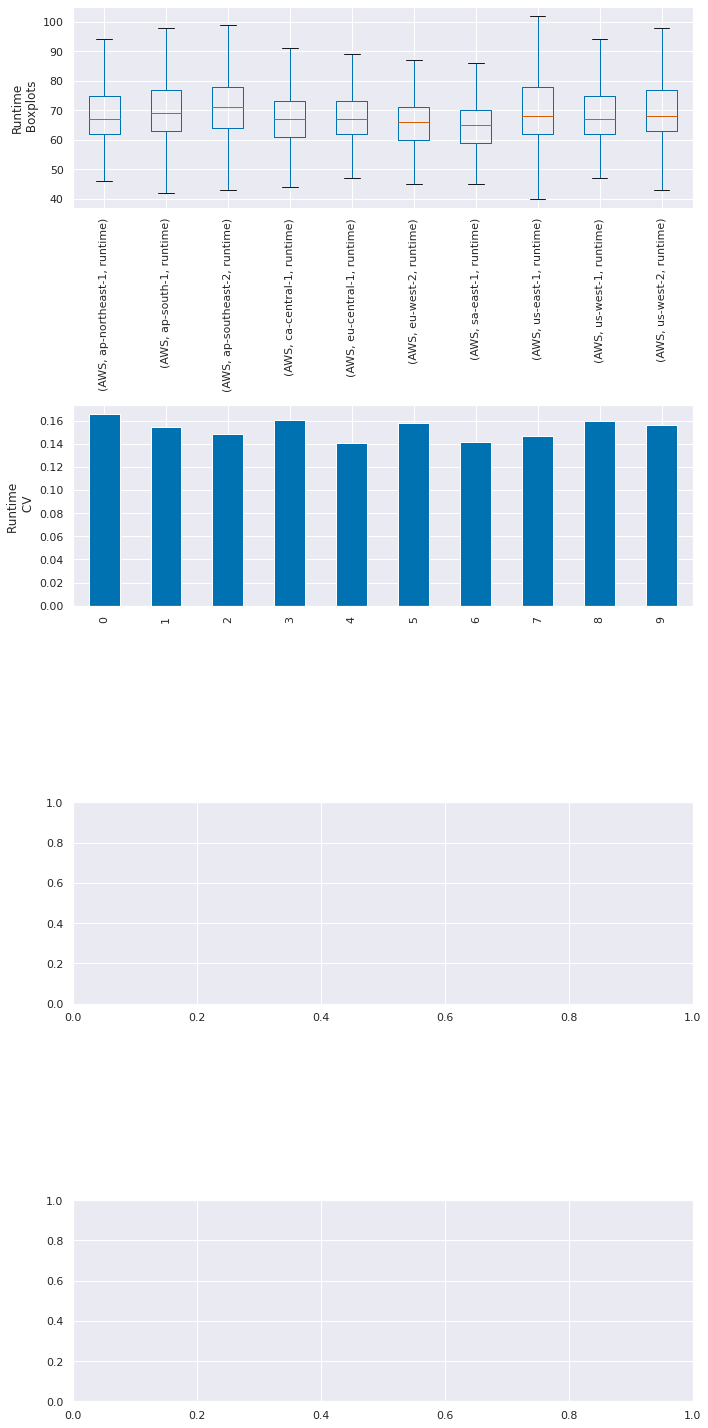

boxplot 
                          runtime                                          \
                           count       mean        std   min   25%   50%   
provider region                                                            
AWS      ap-northeast-1  17370.0  69.449914  11.498890  33.0  62.0  67.0   
         ap-south-1      17364.0  70.704676  10.913137  42.0  63.0  69.0   
         ap-southeast-2  17375.0  71.127482  10.546134  40.0  64.0  71.0   
         ca-central-1    17382.0  68.036762  10.909589  40.0  61.0  67.0   
         eu-central-1    17370.0  68.289983   9.618368  35.0  62.0  67.0   
         eu-west-2       17358.0  67.141030  10.623037  39.0  60.0  66.0   
         sa-east-1       17364.0  65.866563   9.318072  36.0  59.0  65.0   
         us-east-1       17309.0  70.228840  10.279165  31.0  62.0  68.0   
         us-west-1       17358.0  69.494815  11.071164  47.0  62.0  67.0   
         us-west-2       17316.0  70.398706  10.962344  38.0  63.0  68.0   

 

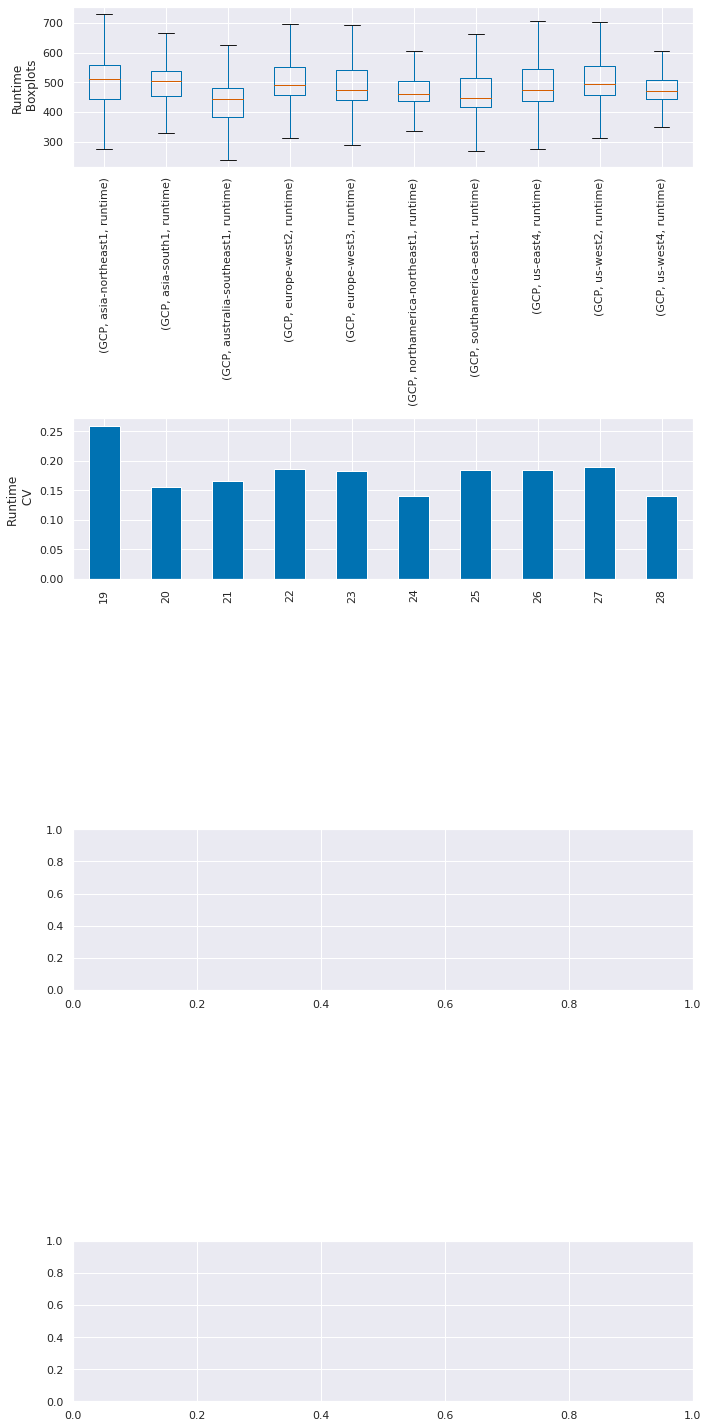

boxplot 
                                   runtime                                 \
                                    count        mean         std    min   
provider region                                                            
GCP      asia-northeast1          17399.0  512.240703  132.788691  146.0   
         asia-south1              17401.0  504.527383   78.153693  171.0   
         australia-southeast1     17405.0  436.331456   71.910657  150.0   
         europe-west2             17400.0  498.717184   92.964757  153.0   
         europe-west3             17403.0  484.635120   88.416021  176.0   
         northamerica-northeast1  17400.0  465.446092   65.125431  152.0   
         southamerica-east1       17397.0  456.039949   83.640062  130.0   
         us-east4                 17403.0  485.229845   89.532139  190.0   
         us-west2                 17400.0  499.634598   94.265091  134.0   
         us-west4                 17400.0  472.868161   66.074685  175.0   

 

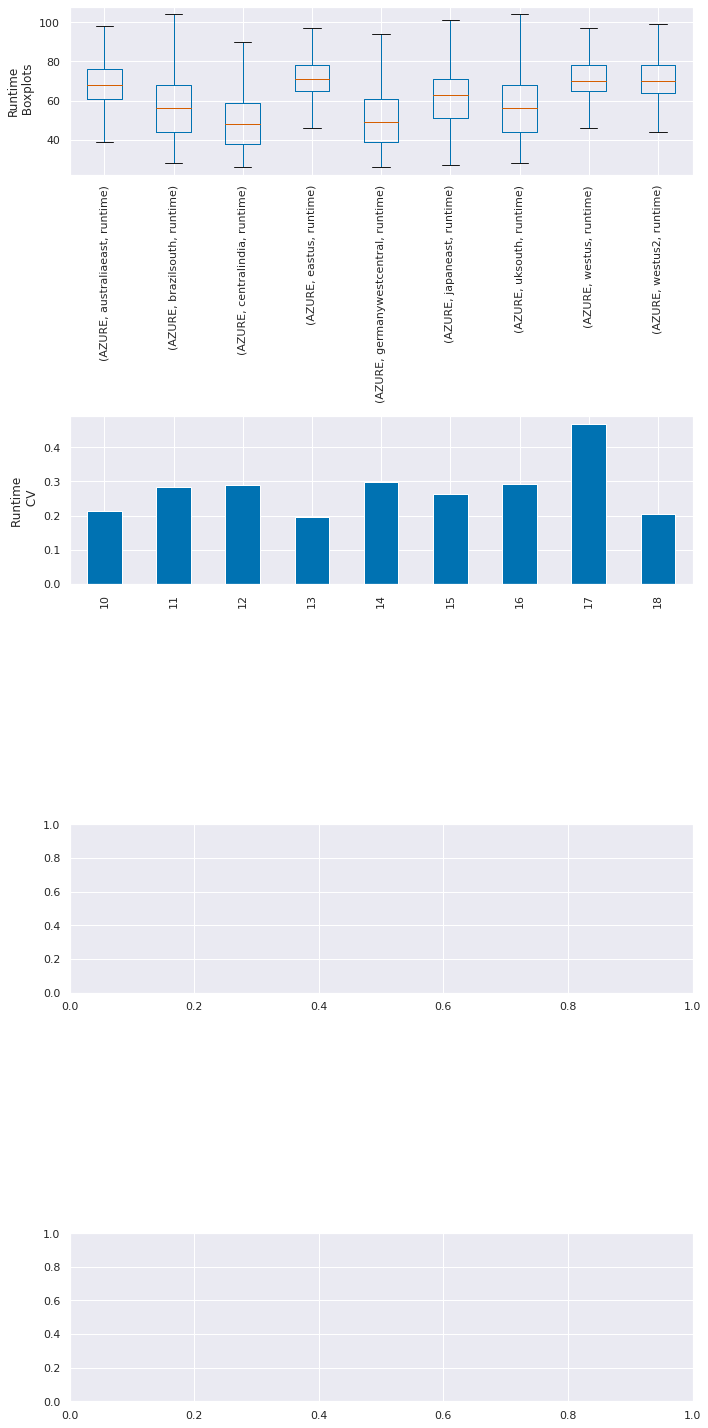

boxplot 
                              runtime                                          \
                               count       mean        std   min   25%   50%   
provider region                                                                
AZURE    australiaeast       14768.0  69.747765  14.807410  39.0  61.0  68.0   
         brazilsouth         17152.0  57.161206  16.292097  28.0  44.0  56.0   
         centralindia        17298.0  49.828362  14.368943  26.0  38.0  48.0   
         eastus              17105.0  73.323414  14.246454  42.0  65.0  71.0   
         germanywestcentral  17309.0  51.202322  15.262342  26.0  39.0  49.0   
         japaneast           17294.0  61.974789  16.320018  27.0  51.0  63.0   
         uksouth             17303.0  57.489510  16.833038  28.0  44.0  56.0   
         westus              16504.0  72.765148  34.187493  44.0  65.0  70.0   
         westus2             17229.0  72.876197  14.937189  39.0  64.0  70.0   

                             

In [40]:
for provider in set(cov_df['provider']):
    SHAREX = False
    fig, axes = plt.subplots(figsize=(10,20), nrows=4, frameon=False, sharex=SHAREX)
    
    # Runtime
    bxdf = df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['provider','region'], observed=True)
    utils.boxplot(axes[0], bxdf, "Runtime\n Boxplots", lambda x: x, rot=90, sharex=SHAREX)
    
    # COV
    cov_provider = cov_df[cov_df['provider'] == provider]
    cov_provider.plot(kind='bar', ax=axes[1], sharex=SHAREX)
    axes[1].get_legend().remove()
    axes[1].set_ylabel('Runtime \n CV')
    
#     # Round Trip Time
#     rtt_df = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider].groupby(['region'], observed=True)
#     utils.boxplot(axes[2], rtt_df, 'Round Trip Time', lambda x: x, rot=90, sharex=SHAREX)
       
#     # resp df
#     resp_df = df[df['provider'] == provider].groupby( ['provider', 'region', 'driver_invocation'], observed=True).size().reset_index(name='counts')
#     df_boxplot = resp_df[['provider', 'region', 'counts']].groupby(['provider', 'region'], observed=True)
#     ax = utils.boxplot(axes[3], df_boxplot, 'Response Count', lambda x: x, rot=90, sharex=SHAREX)
    
#     region_name_ax = ax

    # Set Region Names
    
    labels = []
#     for tick in region_name_ax.get_xticklabels():
#         key = f"({provider}, {tick.get_text()})"
#         mapping = provider_region_mapping[key]
#         region = mapping['region']
#         measure_group = mapping['measure group']
#         labels.append(f"{measure_group}\n({region})")

    # region_name_ax.get_legend().remove()
    # region_name_ax.set_xticklabels(labels)
    # region_name_ax.set_xlabel('')

    fig.tight_layout()

    print(provider)
    utils.plot(f'ra_mean_runtime_{provider}', boxplot=bxdf.describe(), cov=cov_provider)

In [12]:
df_boxplot.count()

,provider,counts
region,,
asia-northeast1,2900,2900
asia-south1,2901,2901
australia-southeast1,2901,2901
europe-west2,2901,2901
europe-west3,2901,2901
northamerica-northeast1,2901,2901
southamerica-east1,2900,2900
us-east4,2901,2901
us-west2,2900,2900


In [ ]:
# Mean Runtime with Outliers
for provider in cov_df.index.get_level_values('provider').unique():
# Generate a control figure - because I cannot fore the matching
    fig, axes = plt.subplots(figsize=(8,5))
    df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
    for tick in axes.get_xticklabels():
        tick.set_rotation(15)
    plt.show()
    plt.close()

# CPU Types Analysis

In [ ]:
unique_cpu_types_df = df.groupby(['measure group', 'provider', 'region'], observed=True)['cpuType'].unique()
unique_cpu_types_count_df = df.groupby(['measure group', 'provider', 'region'], observed=True)['cpuType'].nunique()
unique_cpu_types_count_per_invocation_df = df.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().reset_index()
unique_cpu_types_df, unique_cpu_types_count_df, unique_cpu_types_count_per_invocation_df.groupby(['provider', 'region']).describe()

In [ ]:
# Boxplots over CPUs per Invocation
for provider in unique_cpu_types_count_per_invocation_df['provider'].unique():
  fig, axes = plt.subplots(figsize=(6,3), nrows=1, ncols=1, frameon=False)
  unique_cpu_types_count_per_invocation_df[unique_cpu_types_count_per_invocation_df['provider'] == provider].groupby('region', observed=True).boxplot(subplots=False, rot=45, ax=axes)
  utils.plot(f'ra_cpu_types_in_invocation_{provider}')